# BAKU - Prediction Test for archs comparision
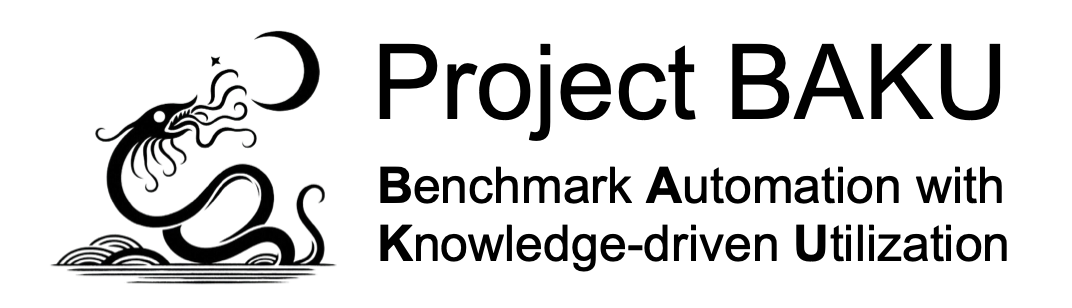


### Imports and Configs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys  
import json
import ast
sys.path.insert(1, '../scripts/benchGen_Dataset/')
import geminiAsker as ga
#import gptAsker as gpt
sys.path.insert(2, '../scripts/classes/')
from data_loader import DataLoader

/home/guima/anaconda3/envs/ml/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup

In [ ]:
def extract_perf_vector(perf_string: str) -> list[float]:

    lines = perf_string.strip().split('\n')
    
    for line in lines:
        if ',' in line and any(char.isdigit() for char in line):
            value_strings = line.split(',')
            
            try:
                perf_vector = [float(val) for val in value_strings]
                return perf_vector
            except ValueError:
                continue
                
    raise Exception("No Vector predicted.")

In [ ]:
def in_confidence_interval(attr: str, value: float, series) -> bool:
    """
    Checks if a value falls within the confidence interval stored in a pandas Series/DataFrame row.
    """
    low_col = attr + "_ic_low"
    high_col = attr + "_ic_high"
    low_bound = float(series[low_col].iloc[0])
    high_bound = float(series[high_col].iloc[0])

    return low_bound <= value <= high_bound

In [ ]:
def prediction_gen(data,models,df_guima,df_natan,api_asker):
    generate_data = DataLoader("../data/prediction_test/results.csv")
    for model in models:
        for dic in data:
            try:
                output = api_asker(prompt=dic["instruction"],model_name=model)
                perf_pred = extract_perf_vector(output)
                
                s_guima = df_guima[df_guima["Program"] == dic["program"]]
                s_natan = df_natan[df_natan["Program"] == dic["program"]]
            
                if s_natan.empty and dic["destination"] == "natan": 
                    continue
                elif not s_natan.empty and dic["destination"] == "natan":
                    result_cpu = in_confidence_interval(attr="cpu-cycles",value=perf_pred[0],series=s_natan)
                    result_instructions = in_confidence_interval(attr="instructions",value=perf_pred[1],series=s_natan)
                    result_cache_ref = in_confidence_interval(attr="cache-references",value=perf_pred[2],series=s_natan)
                    result_cache_misses = in_confidence_interval(attr="cache-misses",value=perf_pred[3],series=s_natan)
                    generate_data.new_row([dic["program"],model,perf_pred[0],perf_pred[1],perf_pred[2],perf_pred[3],"guima","natan",result_cpu,result_instructions,result_cache_ref,result_cache_misses])
            
                if s_guima.empty and dic["destination"] == "guima": 
                    continue
                elif not s_guima.empty and dic["destination"] == "guima":
                    result_cpu = in_confidence_interval(attr="cpu-cycles",value=perf_pred[0],series=s_guima)
                    result_instructions = in_confidence_interval(attr="instructions",value=perf_pred[1],series=s_guima)
                    result_cache_ref = in_confidence_interval(attr="cache-references",value=perf_pred[2],series=s_guima)
                    result_cache_misses = in_confidence_interval(attr="cache-misses",value=perf_pred[3],series=s_guima)
                    generate_data.new_row([dic["program"],model,perf_pred[0],perf_pred[1],perf_pred[2],perf_pred[3],"natan","guima",result_cpu,result_instructions,result_cache_ref,result_cache_misses])
                
                generate_data.save()
            
            except Exception as e:
                print(f"Error:{e}")    
    
    

In [ ]:
df_guima = pd.read_csv("../data/prediction_test/perf_data_guima.csv")

df_natan = pd.read_csv("../data/prediction_test/perf_data_natan.csv")

In [ ]:
input_data = []
gemini_models = ["gemini-2.5-flash","gemini-2.5-pro"]
gpt_models = ["gpt-3.5-turbo-0125"]

with open('../data/prediction_test/prompts_test.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        line_dict = ast.literal_eval(line)
        input_data.append(line_dict)


In [ ]:
prediction_gen(input_data,gemini_models,df_guima,df_natan,ga.geminiAsker)  

In [ ]:
#prediction_gen(input_data,gpt_models,df_guima,df_natan,gpt.openaiAsker)  Do not work for our needs

cpu_bool
False    97
True      7
Name: count, dtype: int64


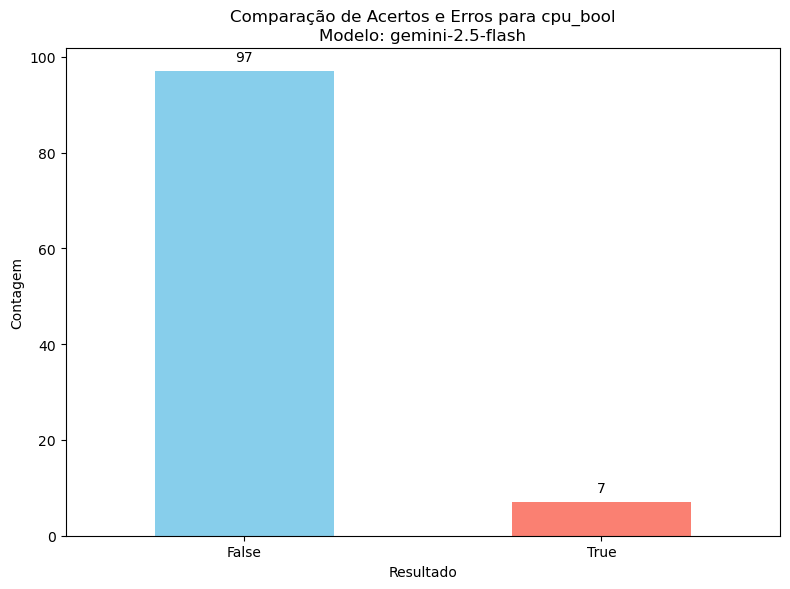

instructions_bool
False    104
Name: count, dtype: int64


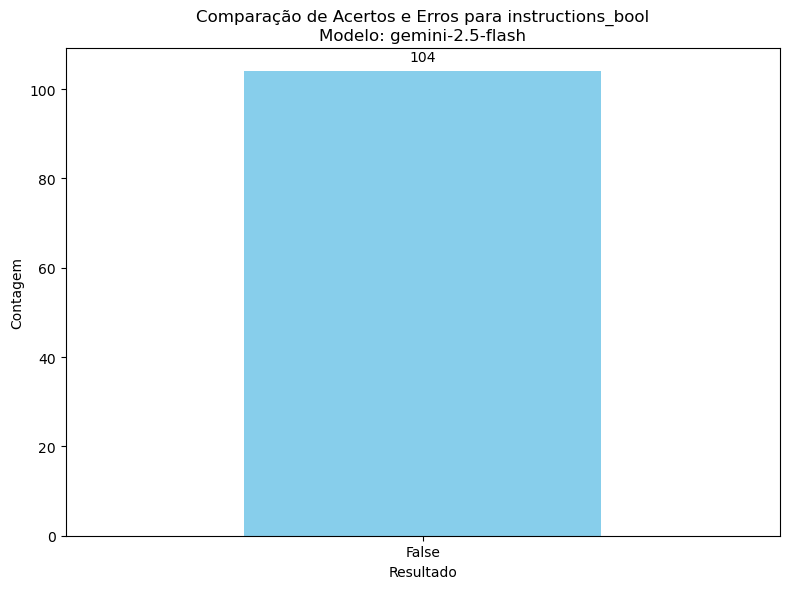

cache_ref_bool
False    103
True       1
Name: count, dtype: int64


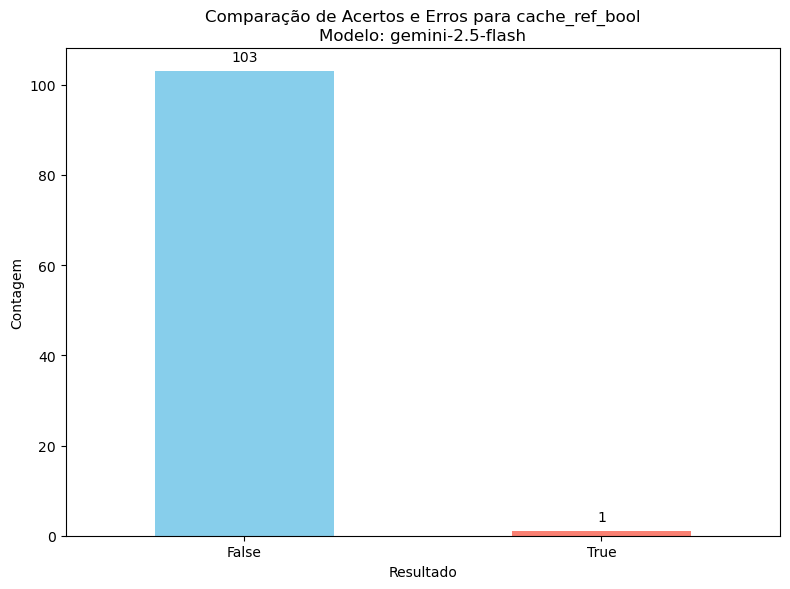

cache_misses_bool
False    98
True      6
Name: count, dtype: int64


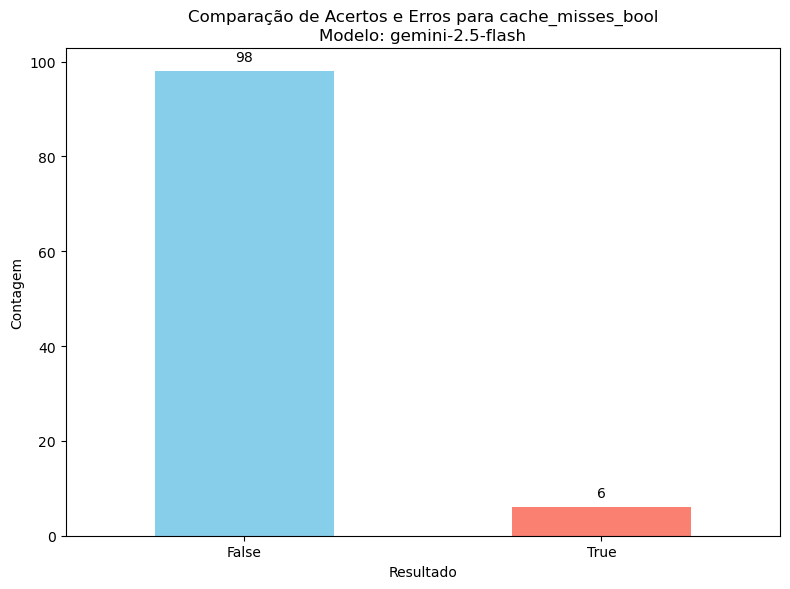




cpu_bool
False    79
True      5
Name: count, dtype: int64


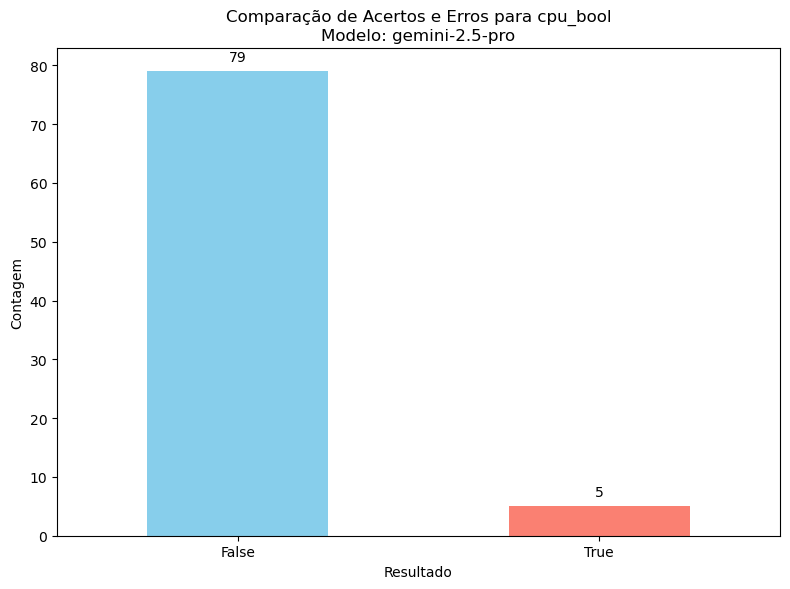

instructions_bool
False    84
Name: count, dtype: int64


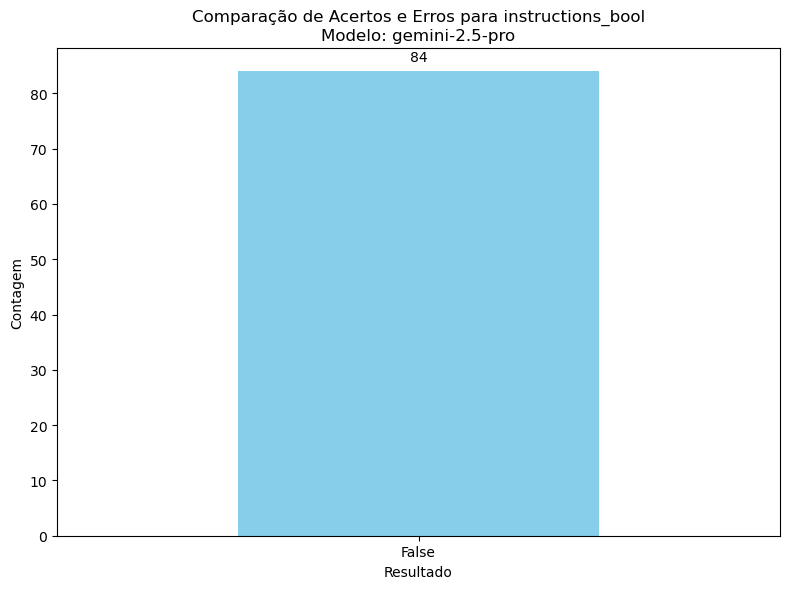

cache_ref_bool
False    84
Name: count, dtype: int64


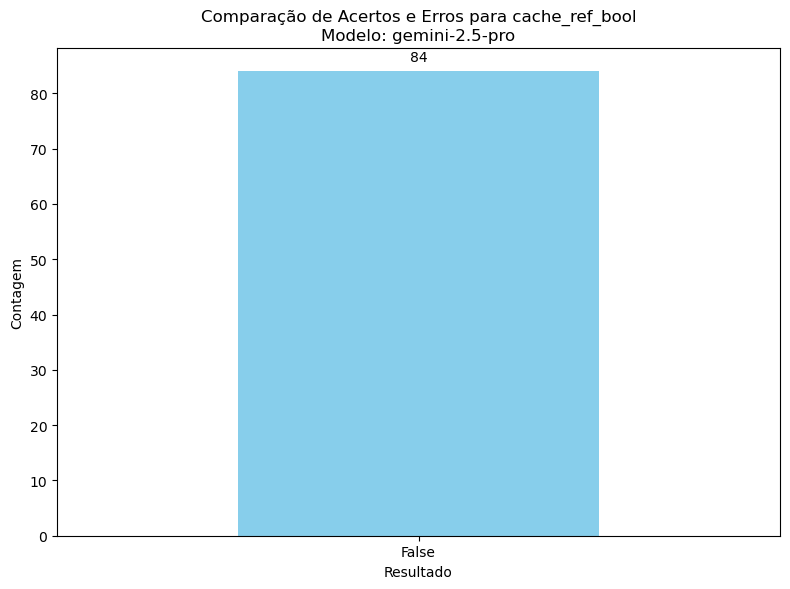

cache_misses_bool
False    79
True      5
Name: count, dtype: int64


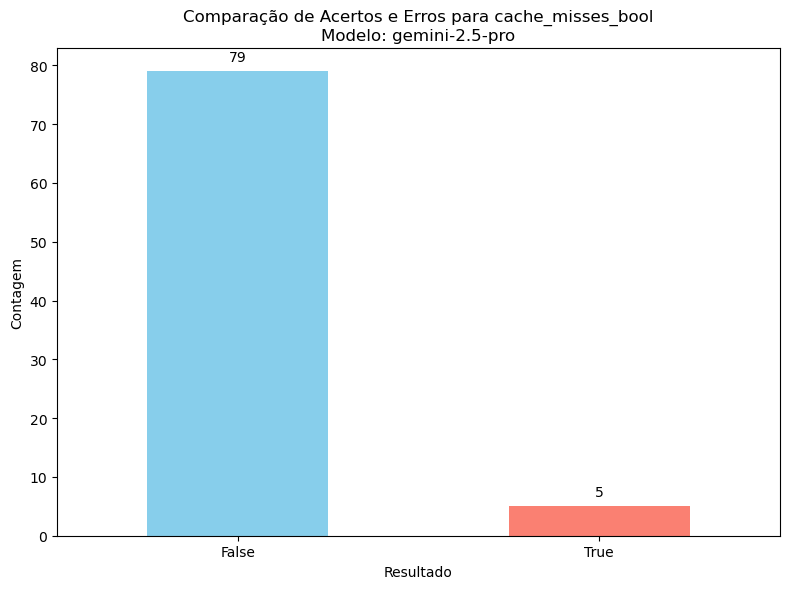

In [3]:
df = pd.read_csv('../data/prediction_test/results.csv')

models = df['model'].unique()

for model in models:
    
    model_df = df[df['model'] == model]
    
    for col in ['cpu_bool', 'instructions_bool', 'cache_ref_bool', 'cache_misses_bool']:
        counts = model_df[col].value_counts()
        
        print(counts)
        
        plt.figure(figsize=(8, 6))
        
        ax = counts.plot(kind='bar', color=['skyblue', 'salmon'])
        
        plt.title(f'Comparação de Acertos e Erros para {col}\nModelo: {model}')
        
        plt.xlabel('Resultado')
        plt.ylabel('Contagem')
        
        plt.xticks(rotation=0)
        
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
        plt.tight_layout()
        
        plt.savefig(f'{model}_{col}_comparison.png')
        plt.show()
        plt.close()
        
    print("\n\n")